In [1]:

!pip install -q kaggle


from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dinusathwik","key":"66767a051cc471c44f7f38dee7fe38c6"}'}

In [2]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
100% 1.02G/1.03G [00:00<00:00, 1.28GB/s]
100% 1.03G/1.03G [00:00<00:00, 1.32GB/s]


In [4]:
!ls -lh
!unzip /content/asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [5]:
!pip install tensorflow

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import zipfile

try:
    from google.colab import files

    if not os.path.exists('/root/.kaggle/kaggle.json'):
        if not os.path.exists('kaggle.json'):
            files.upload()
            print("kaggle.json found in current directory.")

        os.makedirs('/root/.kaggle', exist_ok=True)
        os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
        os.chmod('/root/.kaggle/kaggle.json', 600)
    else:
        print("Kaggle API key already exists.")
except ImportError:
    print("Not in Google Colab. Please ensure kaggle.json is in ~/.kaggle/")


dataset_slug = 'grassknoted/asl-alphabet'
if not os.path.exists('asl_alphabet_train'):
    print("Downloading ASL dataset...")
    os.system(f'kaggle datasets download -d {dataset_slug}')

    with zipfile.ZipFile(f'{dataset_slug.split("/")[1]}.zip', 'r') as zip_ref:
        print("Unzipping dataset...")
        zip_ref.extractall('.')
    print("Dataset ready.")
else:
    print("Dataset already downloaded and extracted.")


Kaggle API key already exists.
Dataset already downloaded and extracted.


In [17]:
IMG_HEIGHT = 200
IMG_WIDTH = 200
BATCH_SIZE = 128
EPOCHS = 15

In [18]:
train_dir = 'asl_alphabet_train/asl_alphabet_train'
test_dir = 'asl_alphabet_test/asl_alphabet_test'


In [19]:
print("Loading datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_dir = 'asl_alphabet_test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Loading datasets...
Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Found 28 files belonging to 1 classes.
Found 29 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [20]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


In [21]:
model = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Add rescaling here
    layers.Conv2D(32,(3, 3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2), #first convolutional block i.e input block
    layers.Conv2D(64, (3, 3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),# second Convolutional block's end
    layers.Conv2D(128, (3, 3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),# Third Convolutional Block's end
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes , activation='softmax') # Use num_classes here

])

In [22]:
model.compile(
        optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 99, 99, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    34,669,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,780,125 (132.68 MB)

 Trainable params: 34,778,653 (132.67 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "asl_model_best.keras"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [26]:
with tf.device("/GPU:0"):
        history=model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,callbacks=[checkpoint_callback])

Epoch 1/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5262 - loss: 1.8009
Epoch 1: val_loss improved from inf to 4.82052, saving model to asl_model_best.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - accuracy: 0.5266 - loss: 1.7993 - val_accuracy: 0.1574 - val_loss: 4.8205
Epoch 2/15
543/544 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9568 - loss: 0.1466
Epoch 2: val_loss improved from 4.82052 to 0.12514, saving model to asl_model_best.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9568 - loss: 0.1465 - val_accuracy: 0.9611 - val_loss: 0.1251
Epoch 3/15
543/544 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9885 - loss: 0.0444
Epoch 3: val_loss did not improve from 0.12514
544/544 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9885 - loss: 0.0444 - val_accuracy: 0.9232 - val_loss: 0.2576
Epoch 4/15
543/544 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9911 - loss: 0.0299
Epoch 4: val_loss did not improve from 0.12514
544/544 ━━━━━━━━━━━━━━━━━━━

In [27]:
print("\nTraining complete.")
print("Using the best validation accuracy as the final performance metric.")
best_val_accuracy = max(history.history['val_accuracy'])
print(f"\nBest Validation Accuracy: {best_val_accuracy*100:.2f}%")


Training complete.
Using the best validation accuracy as the final performance metric.

Best Validation Accuracy: 98.94%


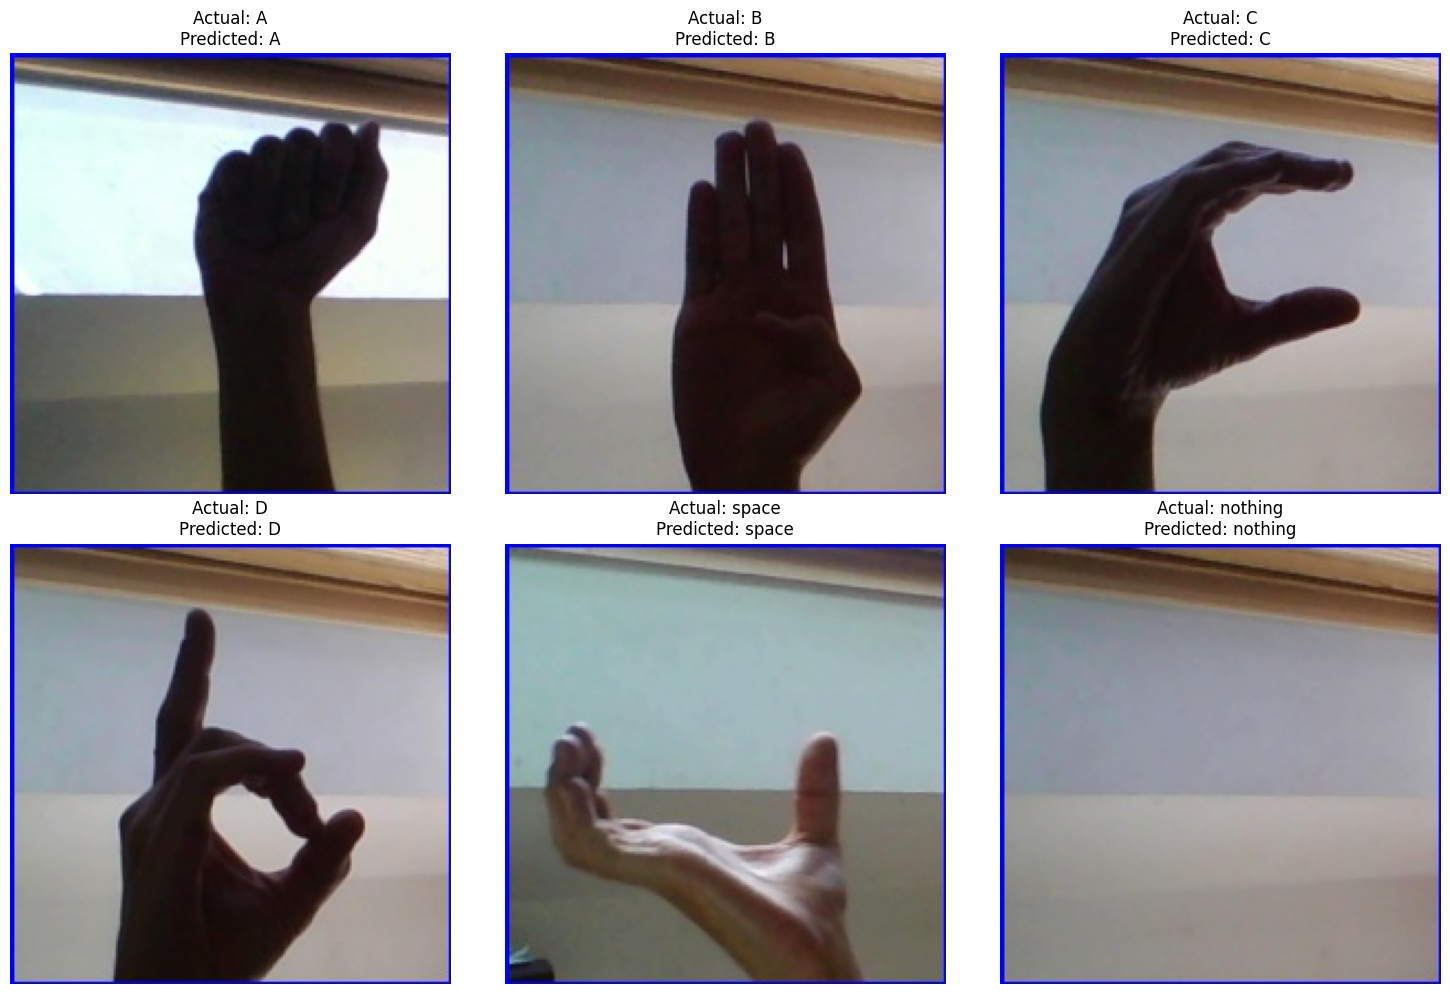

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt


def predict_image(image_path, model):

    img = tf.keras.utils.load_img(
        image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)
    score = tf.nn.softmax(predictions[0])

    predicted_class = class_names[np.argmax(score)]

    return predicted_class, img


test_image_dir = 'asl_alphabet_test/asl_alphabet_test/'
image_paths = [
    os.path.join(test_image_dir, 'A_test.jpg'),
    os.path.join(test_image_dir, 'B_test.jpg'),
    os.path.join(test_image_dir, 'C_test.jpg'),
    os.path.join(test_image_dir, 'D_test.jpg'),
    os.path.join(test_image_dir, 'space_test.jpg'),
    os.path.join(test_image_dir, 'nothing_test.jpg'),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, image_path in enumerate(image_paths):
    try:

        filename = os.path.basename(image_path)
        actual_class = filename.split('_')[0]


        predicted_class, img = predict_image(image_path, best_model)


        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
        ax.axis("off")

    except FileNotFoundError:
        ax = axes[i]
        ax.text(0.5, 0.5, f'Image not found:\n{os.path.basename(image_path)}',
                horizontalalignment='center', verticalalignment='center')
        ax.axis("off")

plt.tight_layout()
plt.show()